In [1]:
from functions import *

In [2]:
# Define parameters 
num_monomers = 20
mean_bond_length = 1
std_bond_length = 20
gaussian_noise_std = 10 

In [3]:
# Generate templates that are at the local minima 
num_templates = 2
template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]

In [8]:
template_dmaps = jnp.array([generate_flatten_distance_map(t) for t in template_chain_list])

In [13]:
# Generate a spectrum of structures between two template chains 
weight_list = jnp.linspace(1, 0, 11)
spectrum_structure_list = [x*template_dmaps[0] + (1-x)*template_dmaps[1] for x in weight_list]

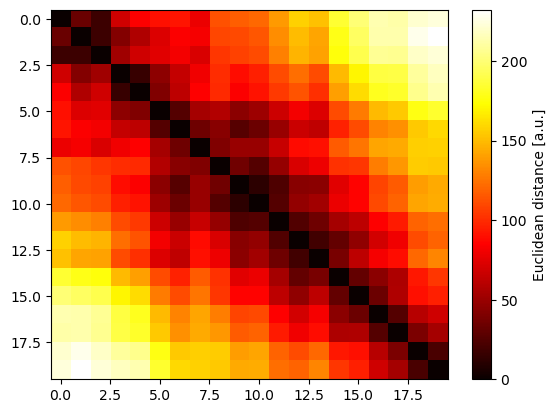

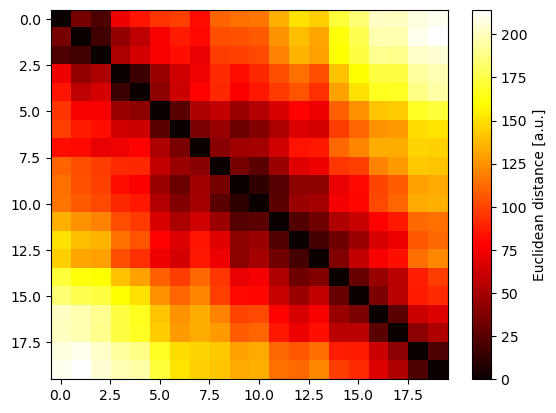

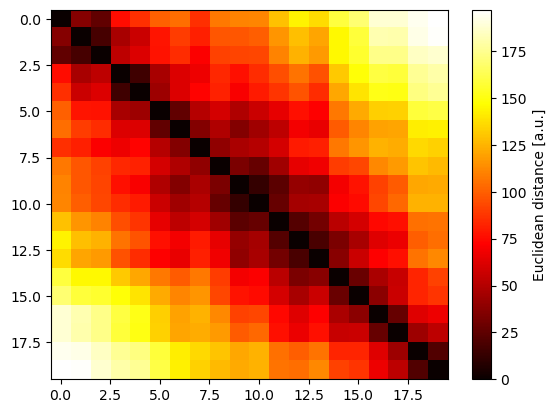

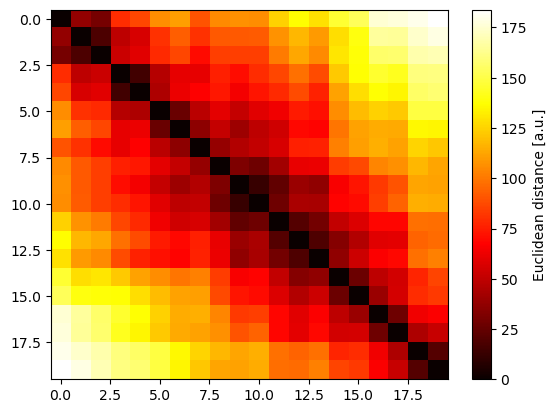

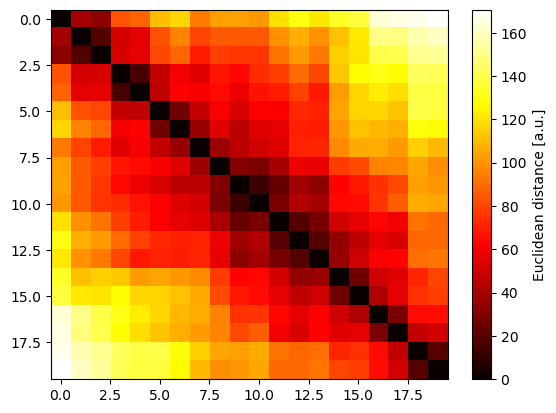

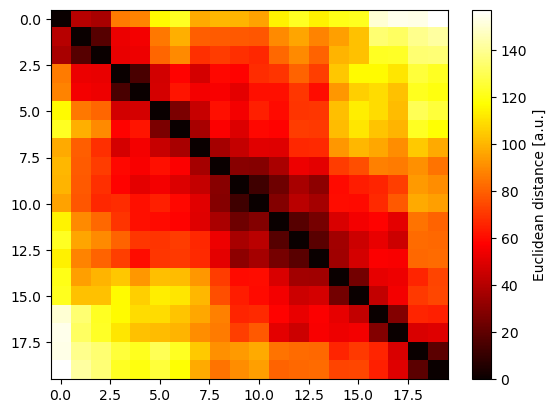

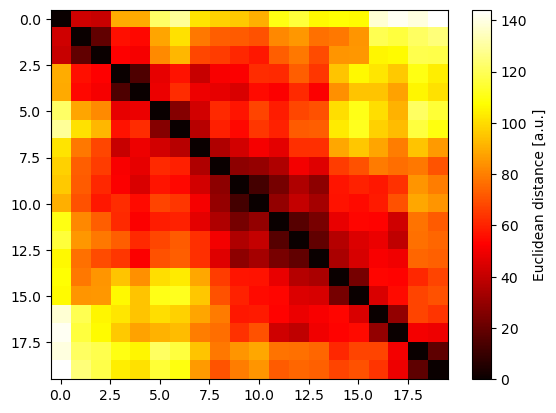

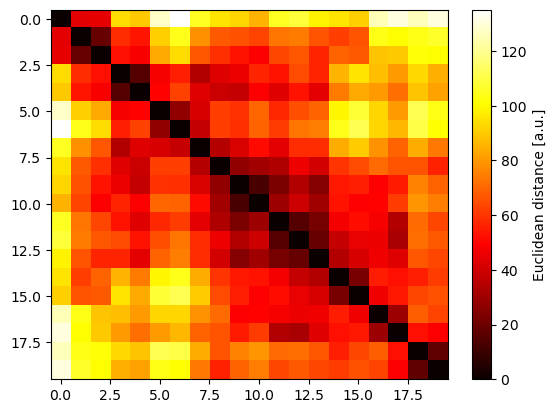

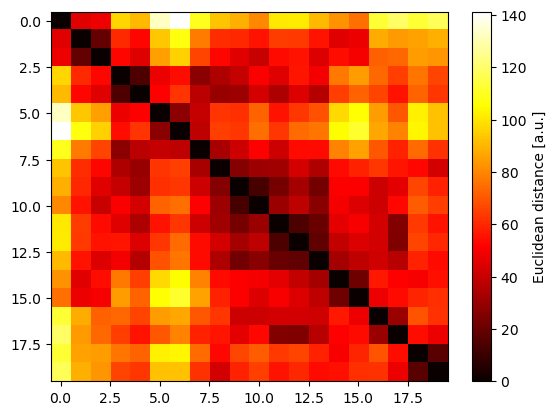

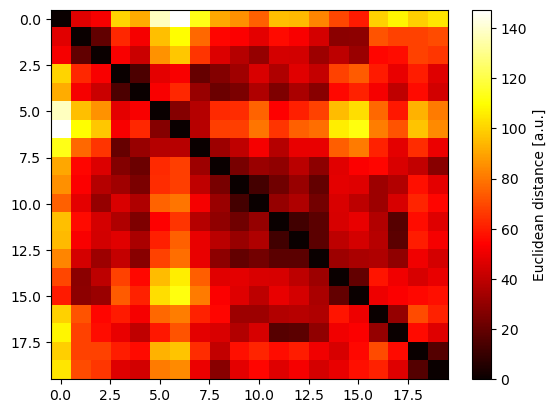

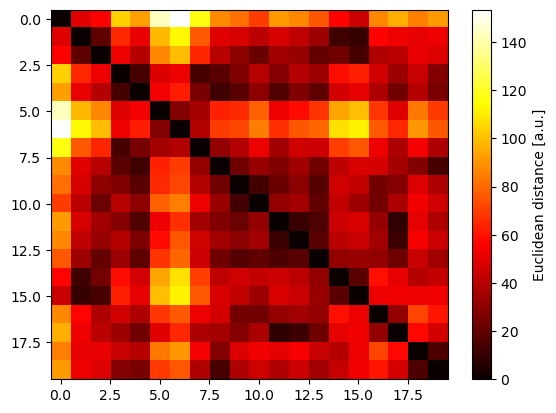

In [14]:
for dmap in spectrum_structure_list:
    visualize_dmap(dmap.reshape(20, 20))

In [28]:
mean = 0
std = gaussian_noise_std
dmap_size = [num_monomers, num_monomers]


num_observation_list = [100, 10, 10, 10, 10, 
                        10, 10, 10, 10, 10, 100]

observations_flatten = []
for i in range(len(spectrum_structure_list)):
    for j in range(num_observation_list[i]):
        noise = np.random.normal(mean, std, dmap_size)
        noise[np.eye(num_monomers).astype(bool)] = 0
        noisy_flatten_dmap = spectrum_structure_list[i] + noise.reshape(-1)
        observations_flatten.append(noisy_flatten_dmap)

In [40]:
observation_class_list = []
for i in range(len(spectrum_structure_list)):
    for j in range(num_observation_list[i]):
        observation_class_list.append(int(i < 6))

In [30]:
def generate_posterior_parallelize(templates, observations_flatten, template_weights, weight_renormalization=1000):
    """
    """
    templates_flatten = [generate_flatten_distance_map(t) for t in templates]
    
    templates_flatten = jnp.array(templates_flatten)
    observations_flatten = jnp.array(observations_flatten)
    
    template_weights = jnp.array(template_weights)
    
    weight_prior = 1/len(template_weights) 
    
    # Generate grid index combination
    template_info_indices = jnp.arange(len(templates_flatten))
    observation_info_indices = jnp.arange(len(observations_flatten))
    t_ind, o_ind = jnp.meshgrid(template_info_indices, observation_info_indices)
    
    total_posterior = 0
    
    t_ind = t_ind.flatten()
    o_ind = o_ind.flatten()
    
    # jax.debug.print("Weights at current iteration: {y}", y=template_weights)
    def calculate_rhs(t_ind, o_ind):
        val = 0 
        o = observations_flatten[o_ind]
        t = templates_flatten[t_ind]
        alpha = template_weights[t_ind]
        
        val += loglikelihood(o, t, measurement_error, num_probes)

        val += logprior(t, num_probes)

        # This is the correct one 
        # But the scaling between alpha and weight priors and logliokelihood are so different 
        # val += jnp.log(alpha + 1e-32) * weight_renormalization 
        val += jnp.log(jnp.abs(alpha) + 1e-32) * weight_renormalization  # use jnp.abs to make sure that each alpha does not go to 0
        val += jnp.log(weight_prior) * weight_renormalization
           
        return val 
    
    def calculate_posterior(i):
        return jscipy.special.logsumexp(jnp.where(o_ind == i, curr_obs_list, -jnp.inf))
    
    curr_obs_list = jnp.array(jax.vmap(calculate_rhs)(t_ind, o_ind))
    
    total_posterior = jnp.sum(jax.vmap(calculate_posterior)(jnp.arange(len(observations_flatten))))

    return total_posterior

def structure_neg_objective_parallelize(observations_flatten):
    """
    """ 
    templates = template_chain_list
    template_weights = num_observation_list
    return -generate_posterior_parallelize(templates, observations_flatten, template_weights)
    

In [31]:
measurement_error = gaussian_noise_std
num_probes = num_monomers

structure_neg_objective_parallelize(observations_flatten)

Array(221888.33, dtype=float32)

In [32]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative
pg = ProjectedGradient(fun=structure_neg_objective_parallelize, projection=projection_non_negative, implicit_diff=True, verbose=True)
pg_sol = pg.run(observations_flatten)

INFO: jaxopt.ProximalGradient: Iter: 1 Distance btw Iterates (stop. crit.): 67.8340072631836 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 2 Distance btw Iterates (stop. crit.): 28.226369857788086 Stepsize:4.0 
INFO: jaxopt.ProximalGradient: Iter: 3 Distance btw Iterates (stop. crit.): 31.47922134399414 Stepsize:8.0 
INFO: jaxopt.ProximalGradient: Iter: 4 Distance btw Iterates (stop. crit.): 32.687801361083984 Stepsize:16.0 
INFO: jaxopt.ProximalGradient: Iter: 5 Distance btw Iterates (stop. crit.): 31.07855796813965 Stepsize:32.0 
INFO: jaxopt.ProximalGradient: Iter: 6 Distance btw Iterates (stop. crit.): 25.14219856262207 Stepsize:64.0 
INFO: jaxopt.ProximalGradient: Iter: 7 Distance btw Iterates (stop. crit.): 13.706340789794922 Stepsize:128.0 
INFO: jaxopt.ProximalGradient: Iter: 8 Distance btw Iterates (stop. crit.): 5.390556335449219 Stepsize:128.0 
INFO: jaxopt.ProximalGradient: Iter: 9 Distance btw Iterates (stop. crit.): 0.058117080479860306 Stepsize:128.0 
INFO: jaxopt.P

In [36]:
sol = pg_sol.params


In [38]:
reducer = umap.UMAP()

Text(0.5, 1.0, 'UMAP projection of distance maps')

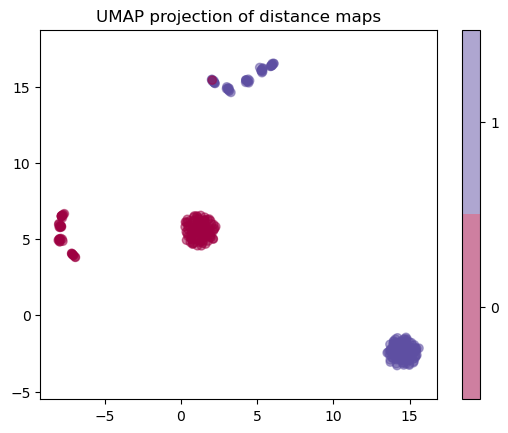

In [44]:
reducer.fit(sol)
embedding = reducer.transform(sol)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=observation_class_list, 
    cmap='Spectral',
    alpha=0.5)
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of distance maps')

In [46]:
# Use SVM to classify results into two classes 

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [47]:
X = sol
y = observation_class_list
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
clf = svm.SVC(kernel='linear', C=1.0)  # You can choose other kernels like 'rbf', 'poly', etc.
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [49]:
# Make predictions
y_pred = clf.predict(X_test)

In [50]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        30

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58



In [ ]:
from sklearn.decomposition import PCA
# Train the SVM model
clf = svm.SVC(kernel='linear', C=1.0)  # You can choose other kernels like 'rbf', 'poly', etc.
clf.fit(X_train, y_train)

# Dimensionality reduction with PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Retrain SVM on reduced data
clf_pca = svm.SVC(kernel='linear', C=1.0)
clf_pca.fit(X_train_pca, y_train)

# Function to plot decision boundary
def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 10, X[:, 0].max() + 10
    y_min, y_max = X[:, 1].min() - 10, X[:, 1].max() + 10
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                         np.arange(y_min, y_max, 1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Plot the decision boundary for training data
plot_decision_boundary(X_train_pca, y_train, clf_pca, "SVM Decision Boundary (Training Data)")

# Plot the decision boundary for test data
plot_decision_boundary(X_test_pca, y_test, clf_pca, "SVM Decision Boundary (Test Data)")